# Lecture 18- Machine Learning with Scikit-Learn

[Scikit-Learn](https://scikit-learn.org/stable/) is a python library of a large number of Machine Learning Algorithms and utilities. Similar to numpy, it's interface is adopted or available by most other Machine Learnings packages. 

## Setup for SUSY Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [3]:
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
RawNames=["l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi"]
FeatureNames=list(set(VarNames[1:]).difference(RawNames))

In [5]:
filename="../../Labs/Lab.7/SUSY.csv"
df = pd.read_csv(filename, dtype='float64', names=VarNames)

In [6]:
df_sig=df[df.signal==1]
df_bkg=df[df.signal==0]

## Problem Formulation

### Define Input/Outputs

### Establishing Train, Test, Validate Samples

In [5]:
N_Train=4000000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


## ML with Scikit-Learn

Scikit-Learn provides a large library of ML algorithms with a common interface which makes it easy to try and compare algorithms.

Last week we created a Fisher discriminant by computing the weights with numpy using the analytical solution. Lets use Scikit-Learn to do the same thing. 

First we instanciate the algorithm:

In [7]:
import sklearn.discriminant_analysis as DA
# Instanciate Method
Fisher=DA.LinearDiscriminantAnalysis()

Then train:

In [8]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

You can immediately apply the algorithm to get predictions (signal or background):

In [9]:
Fisher.predict(X_Test)

array([0., 0., 1., ..., 0., 1., 0.])

What is the prediction doing here? 
* Applying the trained method to get an output (decision_function).
* Using some threshold (most likely at 0) on the output assign to signal/background.

From you previous lab, you should understand that the value of the threshold is something to be tuned and optimized. As you change the threshold, you move on the ROC curve exchanging TPR for FPR.

So lets see the decision function:

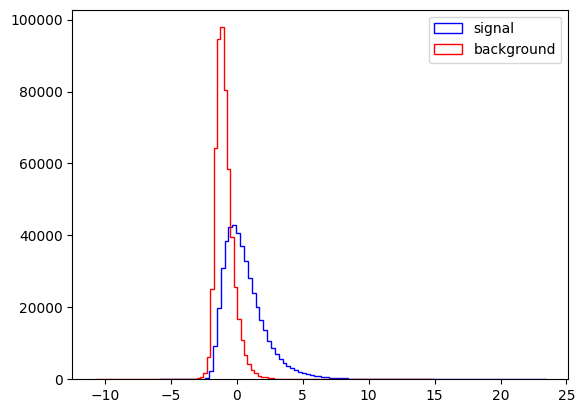

In [10]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

Let's attempt to see what the predict function is doing by plotting the decision output for the signal selected signal and backgournd samples:

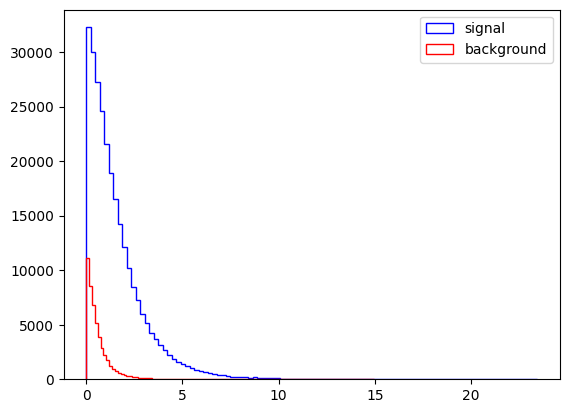

In [11]:
plt.figure()
sig_pred = Test_sig[np.array(Fisher.predict(Test_sig[VarNames[1:]]),dtype="bool")]
plt.hist(Fisher.decision_function(sig_pred[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
bkg_pred = Test_bkg[np.array(Fisher.predict(Test_bkg[VarNames[1:]]),dtype="bool")]
plt.hist(Fisher.decision_function(bkg_pred[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

So predict is equivalent to:

In [12]:
Fisher.decision_function(X_Test)>0

array([False, False,  True, ..., False,  True, False])

Now we can compute the TPR and FPR, plot the ROC curve, and compute the AUC. We've done this before... this time lets use some utilities in Scikit-learn:

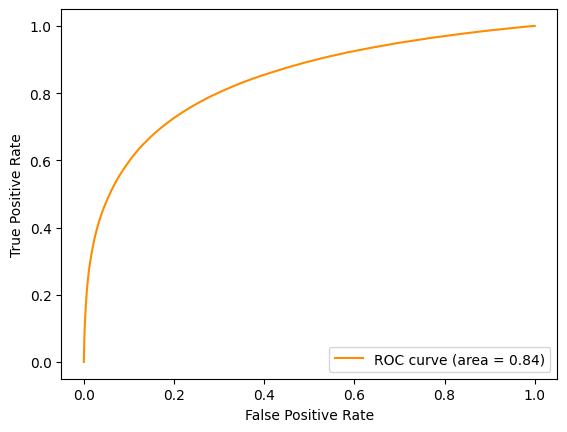

In [13]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

We can easily compute other metrics, for example the f1 score:

In [14]:
from sklearn.metrics import f1_score
f1_score(y_Test, Fisher.predict(X_Test,))

0.6855618176372894

We can change the threshold, if we like:

In [15]:
threshold=-0.1
f1_score(y_Test, np.array(Fisher.decision_function(X_Test)>threshold,dtype='int'))

0.701489100688874

One thing to note is that FPR, TPR, ROC, and AUC do not depend on how much the signal to background ratio. Other metrics, like the f1 score, do depend on the mixture. A common mistake is to quote f1 scores without specifying the signal to background mixture. Lets compute the f1 score with a different mixture of signal and background:

In [16]:
X_sig = X_Test[y_Test==1]
y_sig = y_Test[y_Test==1]

X_bkg = X_Test[y_Test==0]
y_bkg = y_Test[y_Test==0]

print("Sig f1 score:", f1_score(y_sig, Fisher.predict(X_sig)))
print("Bkg f1 score:", f1_score(y_bkg, Fisher.predict(X_bkg)))

N_sig=1000
N_bkg=100000
X_mix = np.concatenate((X_sig[:N_sig],X_bkg[:N_bkg]))
y_mix = np.concatenate((y_sig[:N_sig],y_bkg[:N_bkg]))

print("Mix f1 score:", f1_score(y_mix, Fisher.predict(X_mix)))

Sig f1 score: 0.7317508576394607
Bkg f1 score: 0.0
Mix f1 score: 0.1047700984609502


/Users/afarbin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


## Examples from Scikit-learn

### [An introduction to machine learning with scikit-learn](https://scikit-learn.org/stable/tutorial/basic/tutorial.html)

In [17]:
from sklearn import datasets
iris = datasets.load_iris()
digits = datasets.load_digits()


In [18]:
digits.data.shape

(1797, 64)

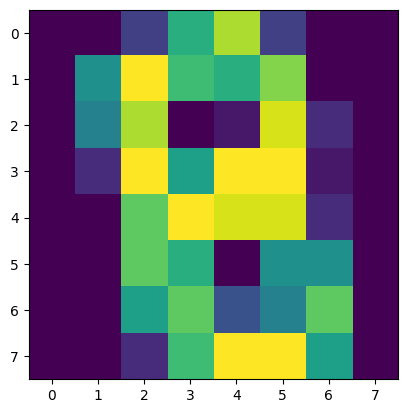

In [19]:
plt.imshow(digits.data[500].reshape((8,8)))

In [20]:
digits.data.shape

(1797, 64)

In [21]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

In [22]:
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [23]:
digits.images.shape

(1797, 8, 8)

In [24]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)


In [25]:
clf.fit(digits.data[:-1], digits.target[:-1])

SVC(C=100.0, gamma=0.001)

In [26]:
clf.predict(digits.data[-1:])

array([8])